# Parameter Tuning

Teil1: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
<br>
Teil2: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
<br>
Teil3: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [1]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [43]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



In [3]:
# load data
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.day
# change type to not get error
df['week'] = df['week'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1152 non-null   datetime64[ns]
 1   n_sick       1152 non-null   int64         
 2   calls        1152 non-null   float64       
 3   n_duty       1152 non-null   int64         
 4   n_sby        1152 non-null   int64         
 5   sby_need     1152 non-null   float64       
 6   dafted       1152 non-null   float64       
 7   year         1152 non-null   int64         
 8   month        1152 non-null   int64         
 9   day_of_week  1152 non-null   int64         
 10  week         1152 non-null   int64         
 11  day          1152 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 117.0 KB


In [4]:
# define X and y data
X = df[['year', 'month', 'day_of_week', 'day',
       'week', 'n_duty', 'n_sby']]
y = df.n_sick

In [5]:
# train test split
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]


x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [6]:
model = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [7]:
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [8]:
pred = model.predict(x_test)

In [9]:
errors = abs(pred - y_test)

In [10]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 13.15 degrees.


In [11]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 81.61 %.


In [12]:
# Saving feature names for later use
feature_list = list(X.columns)
# Convert to numpy array
#features = np.array(X)
#features
feature_list

['year', 'month', 'day_of_week', 'day', 'week', 'n_duty', 'n_sby']

In [13]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: week                 Importance: 0.45
Variable: day                  Importance: 0.14
Variable: year                 Importance: 0.13
Variable: n_duty               Importance: 0.12
Variable: month                Importance: 0.1
Variable: day_of_week          Importance: 0.06
Variable: n_sby                Importance: 0.0


In [14]:
x_train[['week', 'year', 'day', 'day_of_week']].head()

,week,year,day,day_of_week
0,13,2016,1,4
1,13,2016,2,5
2,13,2016,3,6
3,14,2016,4,0
4,14,2016,5,1


--> remove month, day_of_week, n_sby

In [15]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('week'), feature_list.index('year')]
train_important = x_train[['week', 'year']]
test_important = x_test[['week', 'year']]
# Train the random forest
rf_most_important.fit(train_important, y_train)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 12.27 degrees.
Accuracy: 82.7 %.


we need all variables, it doesnt take more time to acquire the information

In [16]:
# Dates of training values
months = X['month']
days = X['day']
years = X['year']
days.min


<bound method NDFrame._add_numeric_operations.<locals>.min of 0        1
1        2
2        3
3        4
4        5
        ..
1147    23
1148    24
1149    25
1150    26
1151    27
Name: day, Length: 1152, dtype: int64>

In [17]:
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]



In [18]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})


In [19]:
# Dates of predictions
months = x_test['month']
days = x_test['day']
years = x_test['year']


In [20]:
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})


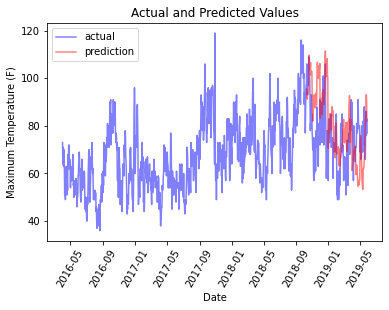

In [21]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [22]:
mean_squared_error(y_test, pred)

263.1340991608696

In [23]:
# tune:
# Create columns of seasons for pair plotting colors
seasons = []
for month in X['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')

<ipython-input-30-aba354b35d2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reduced['season'] = seasons


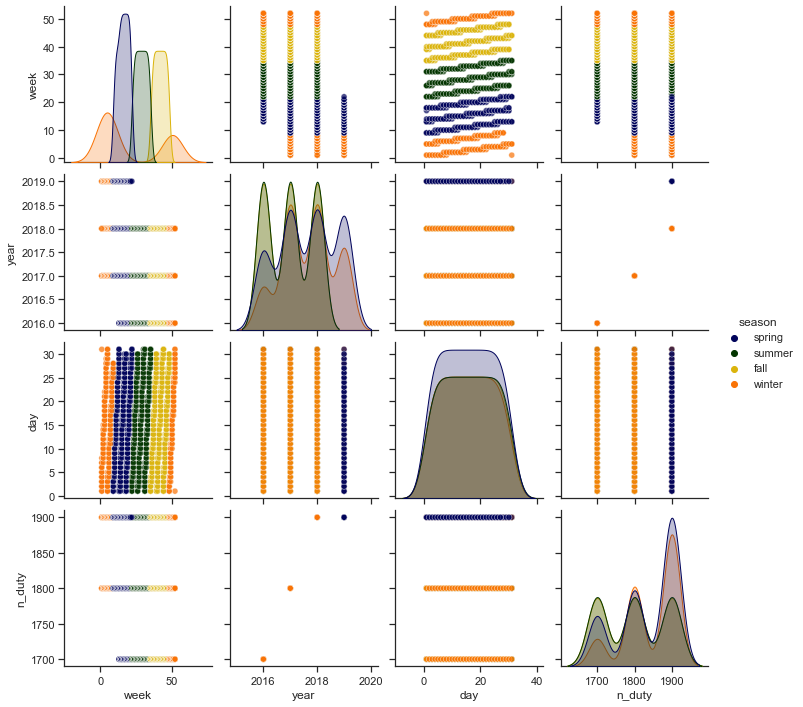

In [30]:
# Will only use six variables for plotting pairs
X_reduced = X[['week', 'year', 'day', 'n_duty']]
X_reduced['season'] = seasons
# Use seaborn for pair plots
sns.set(style="ticks", color_codes=True);
# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])
# Make the pair plot with a some aesthetic changes
sns.pairplot(X_reduced, hue = 'season', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True))

In [31]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [32]:
# grid search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


In [33]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [36]:
# view best parameters
rf_random.best_params_


{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [37]:
# From these results, we should be able to narrow the range of values for each hyperparameter.
# Evaluate Random Search
# To determine if random search yielded a better model, we compare the base model with the best random search model.

def evaluate(model, x_test, y_test):
    predictions = model.predict(x_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [39]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

Model Performance
Average Error: 13.8283 degrees.
Accuracy = 80.70%.


In [41]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)


Model Performance
Average Error: 9.9496 degrees.
Accuracy = 85.88%.


In [42]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 6.42%.


In [44]:
# Grid Search with Cross Validation
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [45]:
# Create a based model
rf = RandomForestRegressor()

In [46]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [48]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 62.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 77.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 92.5min


KeyboardInterrupt: 